In [13]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, stats, fftpack

In [14]:
sys.path.append(r'C:\Users\lesliec\code')

In [15]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_stim_events, find_nearest_ind
from allensdk.brain_observatory.ecephys.lfp_subsampling import subsampling

In [16]:
%matplotlib notebook

### Functions

In [17]:
def get_evoked_traces(data, timestamps, events, plot_before, plot_after, data_sample_rate):
    pre_inds = int(plot_before * data_sample_rate)
    post_inds = int(plot_after * data_sample_rate)
    timex = (np.arange(-pre_inds, post_inds) / data_sample_rate)
    
    evoked_traces = np.zeros((len(timex), np.shape(data)[1], len(events)))
    for j, jtime in enumerate(events):
        zeroind = find_nearest_ind(timestamps, jtime)
        data_inds = np.arange(zeroind-pre_inds, zeroind+post_inds)
        evoked_traces[:,:,j] = data[data_inds,:]
    
    return evoked_traces, timex

In [18]:
def lowpass_filt_design(len_signal, sample_rate, cutoff_freq=200, trans_width=0.2, order_multiple=11, plot_kern=False):
    hz = np.linspace(0, sample_rate/2, int(np.floor(len_signal/2)+1))

    ## determine order
    order = np.round(order_multiple * sample_rate / cutoff_freq) + 1
    if order%2 == 0:
        order += 1 # order must be odd for signal.firls

    shape = [1,1,0,0]
    frex = [0, cutoff_freq, cutoff_freq*(1+trans_width), sample_rate/2]

    # filter kernel
    filtkern = signal.firls(order, frex, shape, fs=sample_rate)

    if plot_kern:
        # its power spectrum
        filtkernX = np.abs(fftpack.fft(filtkern, len_signal))**2

        fig, axs = plt.subplots(1, 2)
        axs[0].plot(np.arange(-order/2, order/2)/sample_rate, filtkern, 'k')
        axs[0].set_xlabel('Time (s)')
        axs[0].set_title('Filter kernel')

        axs[1].plot(np.array(frex), shape, 'r')
        axs[1].plot(hz, filtkernX[:len(hz)], 'k')
        axs[1].set_xlim([0, cutoff_freq*(1+trans_width) + 50])
        axs[1].set_xlabel('Frequency (Hz)')
        axs[1].set_ylabel('Gain')
        axs[1].set_title('Filter kernel spectrum')
        plt.show()
    
    return filtkern

In [19]:
def apply_notch_60Hz(data, sample_rate):
    '''
    Applies a notch filter to remove 60 Hz line noise.
    
    Inputs:
    -------
    data -- nd.array, (samples, channels)
    sample_rate -- int, Hz
    
    Outputs:
    --------
    filtered_data -- nd.array, (samples, channels)
    '''
    notch_freq = 60

    # initialize filtered signal
    filtered_data = data

    # create filter kernel using firwin
    frange = [notch_freq-0.75, notch_freq+0.75]
    order  = int(100*(sample_rate/frange[0]))
    order  = order + ~order%2

    # filter kernel
    filtkern = signal.firwin(order, frange, pass_zero=True, fs=sample_rate)

    # recursively apply to data
    filtered_data = signal.filtfilt(filtkern, 1, filtered_data, axis=0)
    
    return filtered_data

## Load some EEG data

In [20]:
rec_folder = r'C:\Users\lesliec\OneDrive - Allen Institute\data\mouse569068\stim_test_2021-03-04_10-29-44\experiment1\recording1'
exp = EEGexp(rec_folder, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation
SomnoSuite log file not found.
Body camera file not found.
Pupil camera file not found.


In [21]:
## Load stimulus log
stim_log = pd.read_csv(exp.stimulus_log_file)

## Load data
eegdata, eegts = exp.load_eegdata()
eegchs = np.arange(0, eegdata.shape[1])

In [22]:
## Mask the artifacts
mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
for etime in stim_log[stim_log['stim_type'] == 'biphasic'].onset.to_numpy():
    val = find_nearest_ind(eegts, etime) - 2
    eegdata[val:val+mask_samples, :] = eegdata[val:val-mask_samples:-1, :]

### Filtering evoked traces

In [24]:
pick_stim = 'biphasic'
pick_param = 10
pick_sweep = 0

plot_before = 1.0 # s, look at 100 ms pre-stim
plot_after = 1.0 # s, look at 500 ms post-stim

event_times = get_stim_events(stim_log, pick_stim, pick_param, pick_sweep)
event_traces, timex = get_evoked_traces(
    eegdata,
    eegts,
    event_times,
    plot_before,
    plot_after,
    exp.ephys_params['EEG']['sample_rate']
)
event_traces.shape

(5000, 30, 40)

Use baseline subtraction to remove DC offset, then low-pass filter

<IPython.core.display.Javascript object>


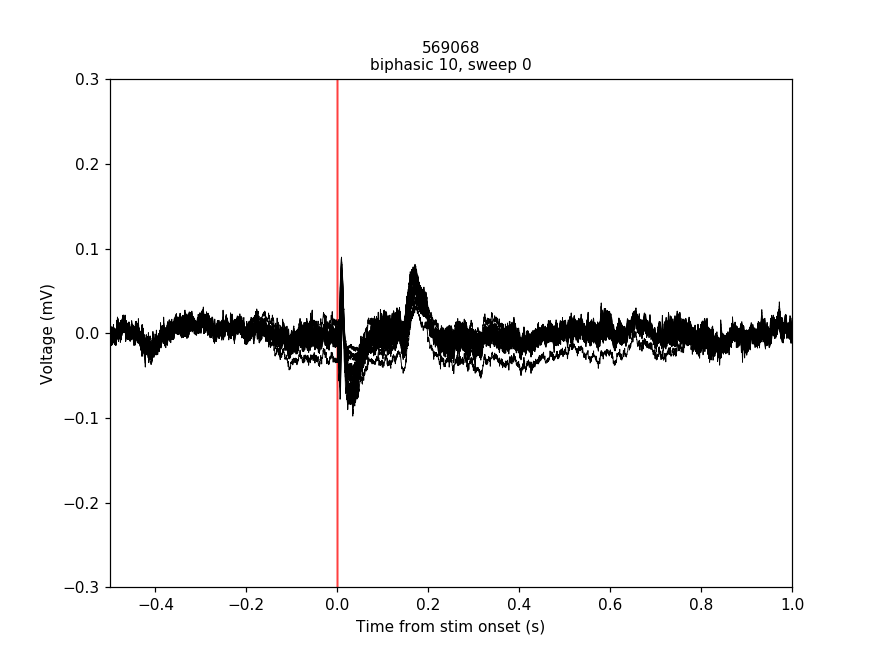

Text(0.5, 1.0, '569068\nbiphasic 10, sweep 0')

In [25]:
prex = .5 # s before stim to plot
postx = 1. # s after stim to plot
ylimit = 0.3 # mV

# plottraces = np.mean(blsub_traces, axis=2)/1000 # make them into mV
plottraces = np.mean(event_traces, axis=2)/1000 # make them into mV
plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(timex[plot_inds], plottraces[plot_inds,:], color='k', linewidth=0.6)
ax.axvspan(-0.001, 0.001, color='r', alpha=0.5)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}, sweep {:d}'.format(exp.mouse, pick_stim, str(pick_param), pick_sweep))

### FIR filter

<IPython.core.display.Javascript object>


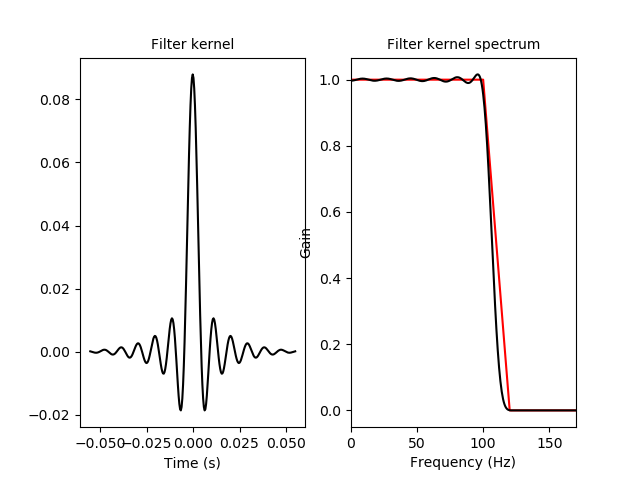

In [14]:
FIR_order = 11
filt_kernel = lowpass_filt_design(
    len(timex),
    exp.ephys_params['EEG']['sample_rate'],
    cutoff_freq=100, # original = 100
    trans_width=0.2, # original = 0.2
    order_multiple=FIR_order, # original = 11
    plot_kern=True
)

In [31]:
FIRfiltered_traces = signal.filtfilt(filt_kernel, 1, blsub_traces, axis=0)

<IPython.core.display.Javascript object>


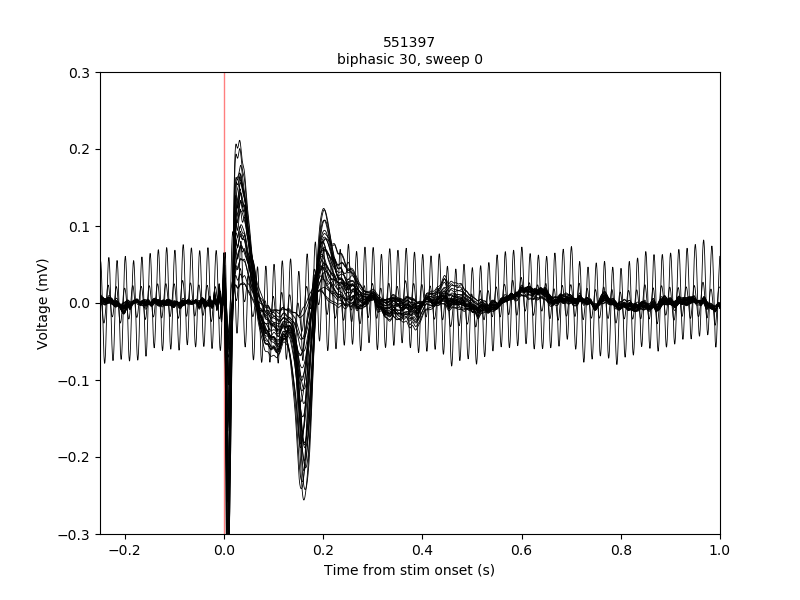

Text(0.5, 1.0, '551397\nbiphasic 30, sweep 0')

In [32]:
prex = .250 # s before stim to plot
postx = 1.0 # s after stim to plot
ylimit = 0.3 # mV

plottraces = np.mean(FIRfiltered_traces, axis=2)/1000 # make them into mV
plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(timex[plot_inds], plottraces[plot_inds,:], color='k', linewidth=0.6)
ax.axvspan(-.001, .001, color='r', alpha=0.5)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}, sweep {:d}'.format(exp.mouse, pick_stim, str(pick_param), pick_sweep))

### Compare a Butterworth filter to an FIR filter on the traces.

<IPython.core.display.Javascript object>


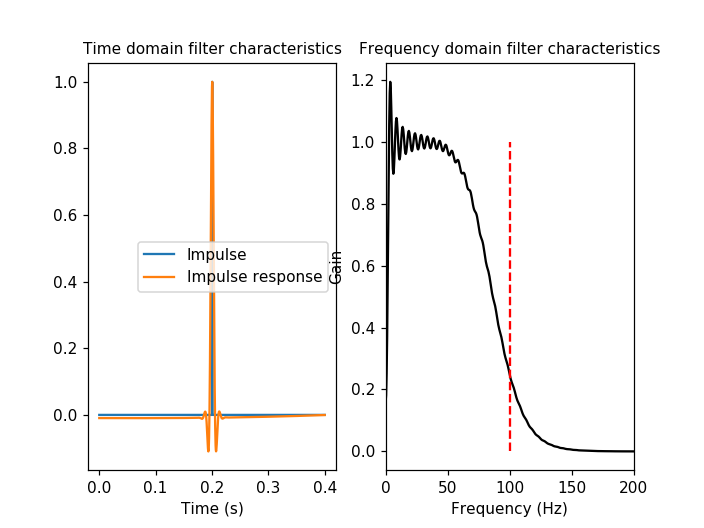

Text(0.5, 1.0, 'Frequency domain filter characteristics')

In [41]:
low_cut = 100 # Hz
BW_order = 3 # common is 3

## Generate filter coefficients (Butterworth) ##
# filtb, filta = signal.butter(BW_order, low_cut/(exp.ephys_params['EEG']['sample_rate']/2), btype='low')
filtb, filta = signal.butter(BW_order, np.array([0.5,low_cut])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')

## Test filter on impulse response function ##
impulse  = np.zeros(1001)
impulse[501] = 1
fimpulse = signal.filtfilt(filtb, filta, impulse)
imptime  = np.arange(0,len(impulse)) / exp.ephys_params['EEG']['sample_rate']

fig, axs = plt.subplots(1,2)
## Plot impulse and IRF ##
axs[0].plot(imptime, impulse, label='Impulse')
axs[0].plot(imptime, fimpulse/np.max(fimpulse), label='Impulse response')
axs[0].set_xlabel('Time (s)')
axs[0].legend()
axs[0].set_title('Time domain filter characteristics')

## Plot spectrum of IRF ##
hz = np.linspace(0, exp.ephys_params['EEG']['sample_rate']/2, 3000)
imppow = np.abs(fftpack.fft(fimpulse, 2*len(hz)))**2
axs[1].plot(hz, imppow[:len(hz)], 'k')
axs[1].plot([low_cut, low_cut], [0, 1], 'r--')
axs[1].set_xlim([0, 200])
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Gain')
axs[1].set_title('Frequency domain filter characteristics')

In [42]:
# BWfiltered_traces = signal.filtfilt(filtb, filta, blsub_traces, axis=0)
BWfiltered_traces = signal.filtfilt(filtb, filta, event_traces, axis=0)

<IPython.core.display.Javascript object>


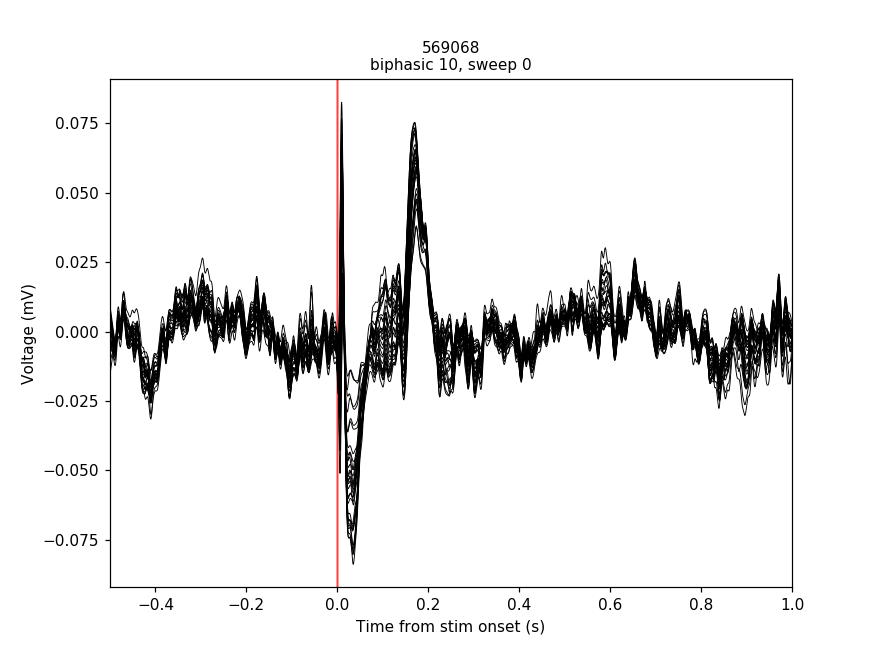

Text(0.5, 1.0, '569068\nbiphasic 10, sweep 0')

In [43]:
prex = 0.5 # s before stim to plot
postx = 1.0 # s after stim to plot
ylimit = 0.5 # mV

plottraces = np.mean(BWfiltered_traces, axis=2)/1000 # make them into mV
plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(timex[plot_inds], plottraces[plot_inds,:], color='k', linewidth=0.6)
ax.axvspan(-.001, .001, color='r', alpha=0.5)

ax.set_xlim([-prex, postx])
# ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}, sweep {:d}'.format(exp.mouse, pick_stim, str(pick_param), pick_sweep))

<IPython.core.display.Javascript object>


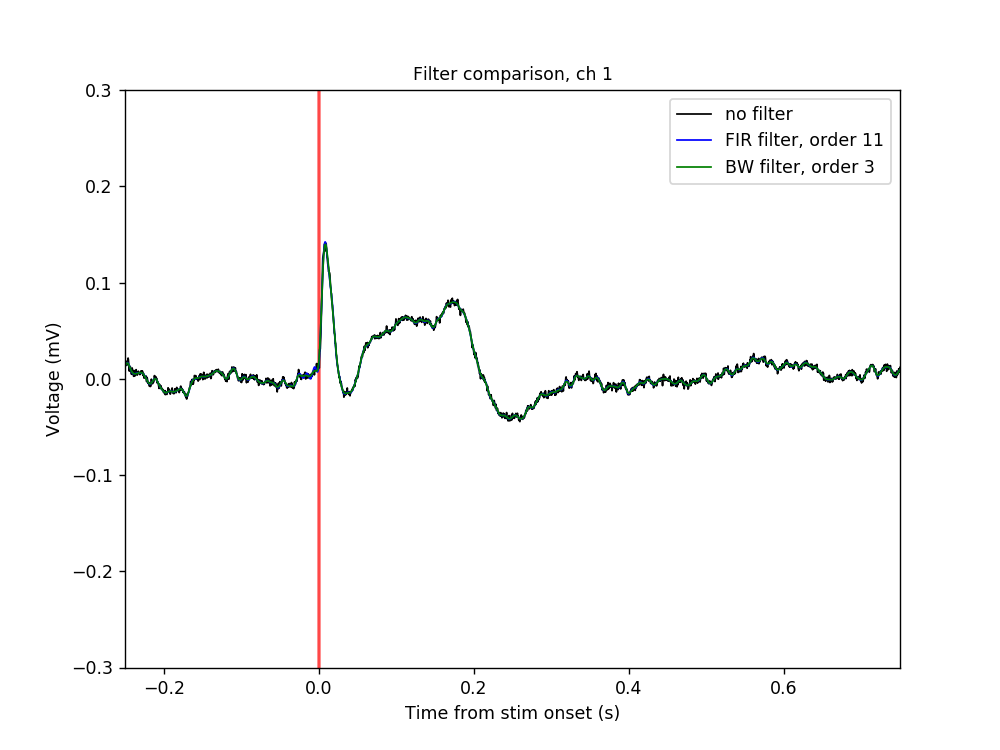

Text(0.5, 1.0, 'Filter comparison, ch 1')

In [20]:
plot_ch = 1
prex = .250 # s before stim to plot
postx = .750 # s after stim to plot
ylimit = 0.3 # mV

rawtraces = np.mean(blsub_traces, axis=2)/1000 # make them into mV
FIRtraces = np.mean(FIRfiltered_traces, axis=2)/1000 # make them into mV
BWtraces = np.mean(BWfiltered_traces, axis=2)/1000 # make them into mV
plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(timex[plot_inds], rawtraces[plot_inds,plot_ch], color='k', linewidth=1, label='no filter')
ax.plot(timex[plot_inds], FIRtraces[plot_inds,plot_ch], color='b', linewidth=1, label='FIR filter, order {:d}'.format(FIR_order))
ax.plot(timex[plot_inds], BWtraces[plot_inds,plot_ch], color='g', linewidth=1, label='BW filter, order {:d}'.format(BW_order))
ax.axvspan(-.001, .001, color='r', alpha=0.5)
ax.legend()
ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('Filter comparison, ch {:d}'.format(plot_ch))

Decreasing the filter order (both FIR and IIR) reduces the duration of the ringing (in the pre-stim period). But in both filters, the broad frequency attenuation suffers. Pre-stim: the Butterworth filtered data matches the raw data the best, but it reduces the magnitude of the short-latency peak response (~7-10 ms). For the rest of the evoked response, the FIR and IIR filtered data are almost exactly the same.

### Try a notch filter for 60 Hz

In [22]:
notch_freq = 60
n_order_mult = 100

# create filter kernel using firwin
frange = [notch_freq-0.75, notch_freq+0.75]
norder  = int(n_order_mult*(exp.ephys_params['EEG']['sample_rate']/frange[0]))
norder  = norder + ~norder%2

# filter kernel
notch_kern = signal.firwin(norder, frange, pass_zero=True, fs=exp.ephys_params['EEG']['sample_rate'])

<IPython.core.display.Javascript object>


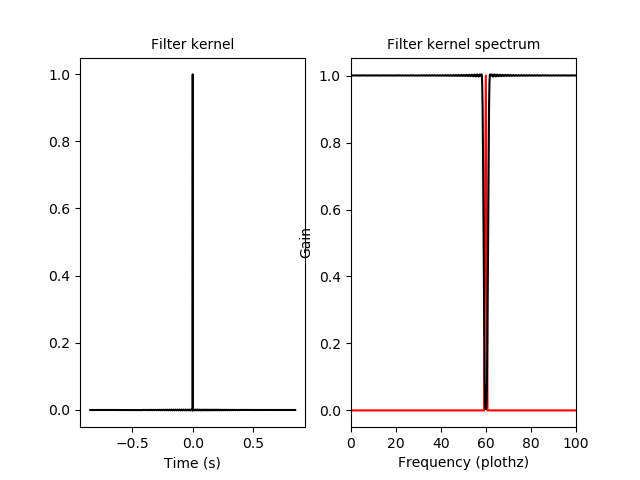

In [23]:
plothz = np.linspace(0, exp.ephys_params['EEG']['sample_rate']/2, int(np.floor(len(timex)/2)+1))

# its power spectrum
notch_kernX = np.abs(fftpack.fft(notch_kern, len(timex)))**2

fig, axs = plt.subplots(1, 2)
axs[0].plot(np.arange(-norder/2, norder/2)/exp.ephys_params['EEG']['sample_rate'], notch_kern, 'k')
axs[0].set_xlabel('Time (s)')
axs[0].set_title('Filter kernel')

axs[1].plot(np.array([0, frange[0], notch_freq, frange[1], exp.ephys_params['EEG']['sample_rate']/2]), [0,0,1,0,0], 'r')
axs[1].plot(plothz, notch_kernX[:len(plothz)], 'k')
axs[1].set_xlim([0, 100])
axs[1].set_xlabel('Frequency (plothz)')
axs[1].set_ylabel('Gain')
axs[1].set_title('Filter kernel spectrum')
plt.show()

In [24]:
# recursively apply to data
notch_data = signal.filtfilt(notch_kern, 1, BWfiltered_traces, axis=0)

<IPython.core.display.Javascript object>


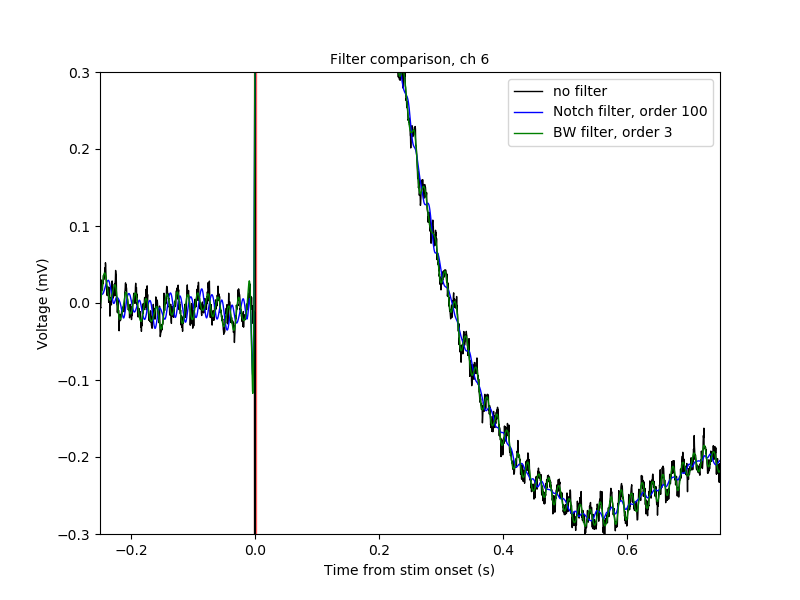

Text(0.5, 1.0, 'Filter comparison, ch 6')

In [25]:
plot_ch = 6
prex = .250 # s before stim to plot
postx = .750 # s after stim to plot
ylimit = 0.3 # mV

rawtraces = np.mean(blsub_traces, axis=2)/1000 # make them into mV
notchtraces = np.mean(notch_data, axis=2)/1000 # make them into mV
BWtraces = np.mean(BWfiltered_traces, axis=2)/1000 # make them into mV
plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(timex[plot_inds], rawtraces[plot_inds,plot_ch], color='k', linewidth=1, label='no filter')
ax.plot(timex[plot_inds], notchtraces[plot_inds,plot_ch], color='b', linewidth=1, label='Notch filter, order {:d}'.format(n_order_mult))
ax.plot(timex[plot_inds], BWtraces[plot_inds,plot_ch], color='g', linewidth=1, label='BW filter, order {:d}'.format(BW_order))
ax.axvspan(-.001, .001, color='r', alpha=0.5)
ax.legend()
ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('Filter comparison, ch {:d}'.format(plot_ch))

### Tried a Butterworth filter of different orders to remove DC offset, but the filter design doesn't look very good.

Use a Butterworth to perform high-pass filter to remove DC offset caused by previous stim artifact

In [20]:
high_cut = 0.5 # Hz

## Generate filter coefficients (Butterworth) ##
filtb, filta = signal.butter(3, high_cut/(exp.ephys_params['EEG']['sample_rate']/2), btype='high')

<IPython.core.display.Javascript object>


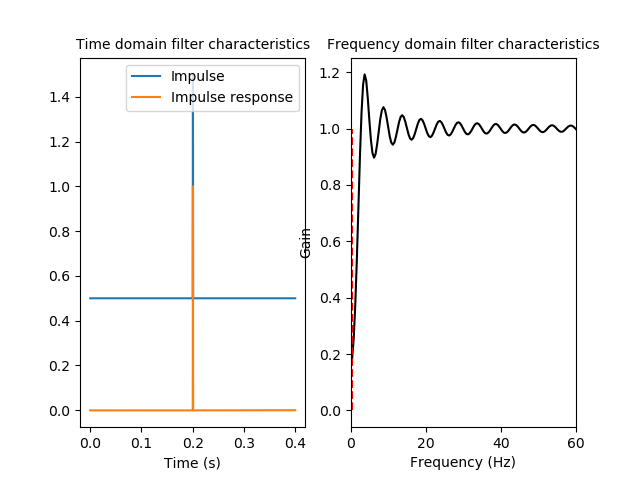

Text(0.5, 1.0, 'Frequency domain filter characteristics')

In [21]:
## Test filter on impulse response function ##
impulse  = np.zeros(1001)
impulse[501] = 1
impulse = impulse + 0.5
fimpulse = signal.filtfilt(filtb, filta, impulse)
imptime  = np.arange(0,len(impulse)) / exp.ephys_params['EEG']['sample_rate']

fig, axs = plt.subplots(1,2)
## Plot impulse and IRF ##
axs[0].plot(imptime, impulse, label='Impulse')
axs[0].plot(imptime, fimpulse/np.max(fimpulse), label='Impulse response')
axs[0].set_xlabel('Time (s)')
axs[0].legend()
axs[0].set_title('Time domain filter characteristics')

## Plot spectrum of IRF ##
hz = np.linspace(0, exp.ephys_params['EEG']['sample_rate']/2, 3000)
imppow = np.abs(fftpack.fft(fimpulse, 2*len(hz)))**2
axs[1].plot(hz, imppow[:len(hz)], 'k')
axs[1].plot([high_cut, high_cut], [0, 1], 'r--')
axs[1].set_xlim([0, 60])
axs[1].set_xlabel('Frequency (Hz)')
axs[1].set_ylabel('Gain')
axs[1].set_title('Frequency domain filter characteristics')

## Mask the artifact

<IPython.core.display.Javascript object>


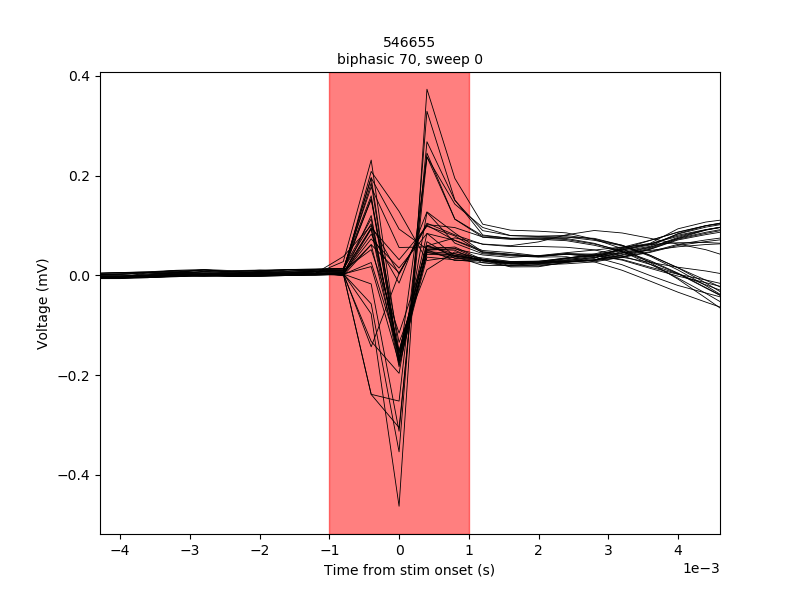

Text(0.5, 1.0, '546655\nbiphasic 70, sweep 0')

In [12]:
prex = .5 # s before stim to plot
postx = 1. # s after stim to plot
ylimit = 1. # mV

plottraces = np.mean(event_traces, axis=2)/1000 # make them into mV
plot_inds = np.squeeze(np.argwhere((timex >= -prex) & (timex <= postx)))

fig, ax = plt.subplots(figsize=(8,6))

ax.plot(timex[plot_inds], plottraces[plot_inds,:], color='k', linewidth=0.6)
ax.axvspan(-0.001, 0.001, color='r', alpha=0.5)

ax.set_xlim([-prex, postx])
ax.set_ylim([-ylimit, ylimit])
ax.set_xlabel('Time from stim onset (s)')
ax.set_ylabel('Voltage (mV)')
ax.set_title('{}\n{} {}, sweep {:d}'.format(exp.mouse, pick_stim, str(pick_param), pick_sweep))

In [ ]:
# np.squeeze(np.argwhere((timex > -0.5) & (timex < -0.005)))
# datamm[val:val+mask_samples,:] = datamm[val:val-mask_samples:-1,:]

### Filtering the whole recording

#### Let's choose one channel and filter in different ways

In [11]:
choose_cha = 2 # choose which electrode to plot (zero-indexed, ch 30:31 do not exist)

# load single ch data
cha = eegdata[:, choose_cha]

#### FIR lowpass filter

<IPython.core.display.Javascript object>


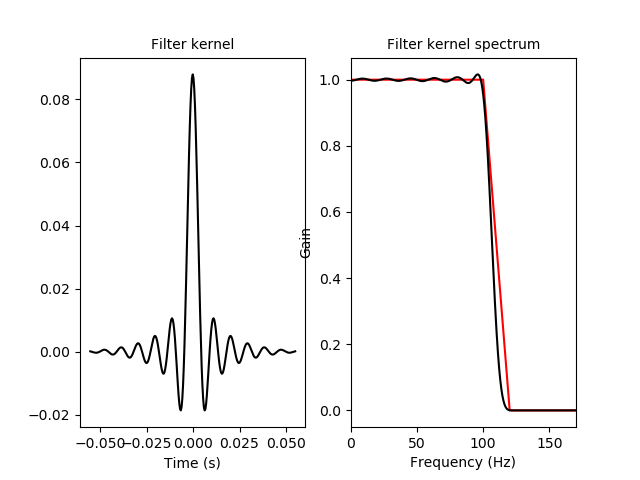

In [21]:
fir_kernel = lowpass_filt_design(
    len(eegts),
    exp.ephys_params['EEG']['sample_rate'],
    cutoff_freq=100,
    trans_width=0.2,
    order_multiple=11,
    plot_kern=True
)

In [22]:
fir_cha = signal.filtfilt(fir_kernel, 1, cha, axis=0)

#### Butterworth lowpass

In [23]:
fc = 100  # Cut-off frequency of the filter
w = fc / (exp.ephys_params['EEG']['sample_rate'] / 2) # Normalize the frequency
b, a = signal.butter(5, w, 'low')

In [24]:
butter_cha = signal.filtfilt(b, a, cha)

#### Mask the artifact

In [12]:
mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
mask_cha = cha.copy()
for event in stim_log[stim_log['stim_type'] == 'biphasic'].onset.to_numpy():
    val = find_nearest_ind(eegts, event) - 2
    mask_cha[val:val+mask_samples] = mask_cha[val:val-mask_samples:-1]

### Plot the results

<IPython.core.display.Javascript object>


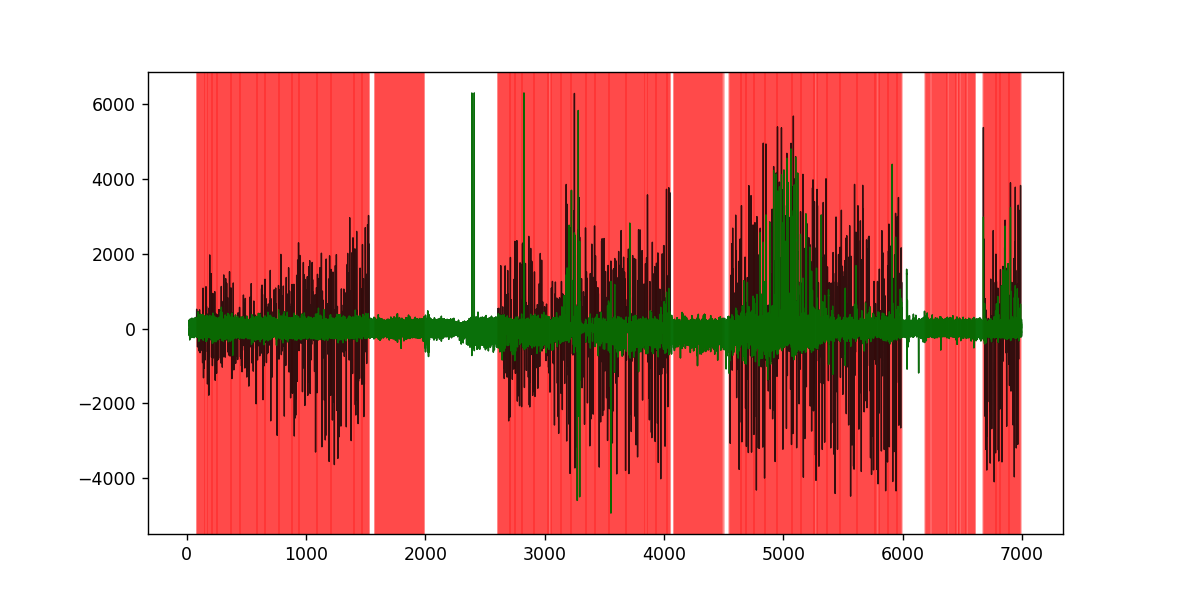

In [13]:
fig, ax = plt.subplots()
ax.plot(eegts, cha, 'k', alpha=0.8, linewidth=0.8)
ax.plot(eegts, mask_cha, 'g', alpha=0.8, linewidth=0.8)
# ax.plot(eegts, fir_cha, 'r', alpha=0.8, linewidth=0.8)
# ax.plot(eegts, butter_cha, 'b', alpha=0.8, linewidth=0.8)
for event in stim_log.onset.to_numpy():
#     ax.axvline(event, color='r', linewidth=0.6)
    ax.axvspan(event-0.0008, event-0.0008+0.002, color='r', alpha=0.3)

Not an appreciable difference between the FIR and the Butterworth filter.

In [19]:
2/30000

6.666666666666667e-05

In [21]:
x_fillin = np.array([3, 4, 5, 6])
x_ends = np.array([2, 7])
y_ends = np.array([4, 14])

print(np.interp(x_fillin, x_ends, y_ends))

[ 6.  8. 10. 12.]
